In [1]:
%matplotlib notebook

import os, sys, datetime
import matplotlib.pyplot as plt
import numpy as np

#sys.path.append(r"D:\Code")
import qcodes as qc
# import characterizations.characterizations.mobility as mobility
from qcodes.dataset.data_set import DataSet, load_by_id
from qcodes.dataset.experiment_container import Experiment
import numpy as np
import scipy as sp
import scipy.optimize as spo
import matplotlib.pyplot as plt

In [79]:
from qcodes.dataset.database import initialise_database, get_DB_location

qc.config["core"]["db_location"] = r'D:\OneDrive\BF3\Data\experiments_2018-09.db'
initialise_database()

### Pinchoff fitting FEM

R_s = 18.004880437727063 kOhm
mu = 7477.0200938534745 cm^2/Vs
V_th = 0.14482365485191687 V
L = 2.885 um
C = 2.0 fF


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide


<IPython.core.display.Javascript object>


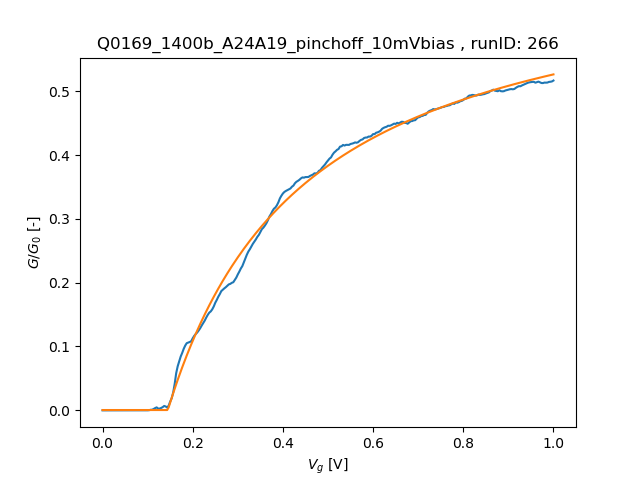

In [80]:
runid = 266

dat = load_by_id(runid)
exp = Experiment(dat.path_to_db)
exp.exp_id = dat.exp_id
# dat.exp_name = exp.name

cur = dat.get_values('current')
V_g = dat.get_values('mdac_gate_voltage')
npoints = int(len(V_g)/2)
V_gs, curs = np.array(V_g)[npoints:,0], np.array(cur)[npoints:,0]

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
# Define callable function that returns values from the fitting function
# G(V_g) = (R_s + L^2 / (mu * C (V_g - V_th)))^-1
# R_s = params[0]       mu * C = params[1]      V_th = params[2]
L = 2.885E-6; # meter
C = 2E-15; # Farad
V_bias = 10E-3; # Volt
def fitfunc(xdata, *params):
    return 1 * (xdata > params[2]) / (params[0] + L**2 / (params[1] * (xdata - params[2])));

I = curs
V_g = V_gs

G_0 = 1 / 12906; # Siemens
G = I / V_bias; # Siemens

[fitted, _] = spo.curve_fit(fitfunc, V_g, G, p0 = [18E3, 2E-15, 0]);

print('R_s = {} kOhm\nmu = {} cm^2/Vs\nV_th = {} V\nL = {} um\nC = {} fF'.format(fitted[0] * 1E-3, fitted[1] / C * 1E4, fitted[2], L*1E6, C/1e-15));

plt.figure('fitting')
plt.plot(V_g, G / G_0, V_g, fitfunc(V_g, *fitted) / G_0);
plt.title(dat.exp_name+ ' , runID: ' + str(runid));
plt.xlabel('$V_g$ [V]');
plt.ylabel('$G / G_0$ [-]')
plt.show();


<IPython.core.display.Javascript object>


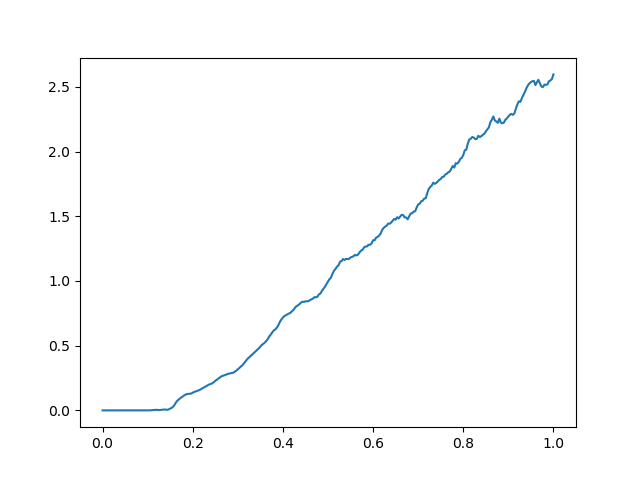

In [81]:
plt.figure('after subtraction')

plt.plot(V_g, 12906/(1/G-20e3))